In [1]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from smr import File
import numpy as np
from matplotlib import pyplot as plt
from kaveh.behavioral import oculomotor
from kaveh import plots

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [135]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091208/B091208_1545_List.smr'
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)


In [136]:
chan_titles = [chan.title for chan in smr_content.channels]
for i, ct in enumerate(chan_titles):
    print("{}: {}".format(i, ct))

0: Unit
1: H Eye
2: V Eye
3: H Targ
4: V Targ
5: H2 Targ
6: V2 Targ
7: Aux 1
8: Aux 2
9: Accept Sp
10: Keyboard
11: Events


<IPython.core.display.Javascript object>


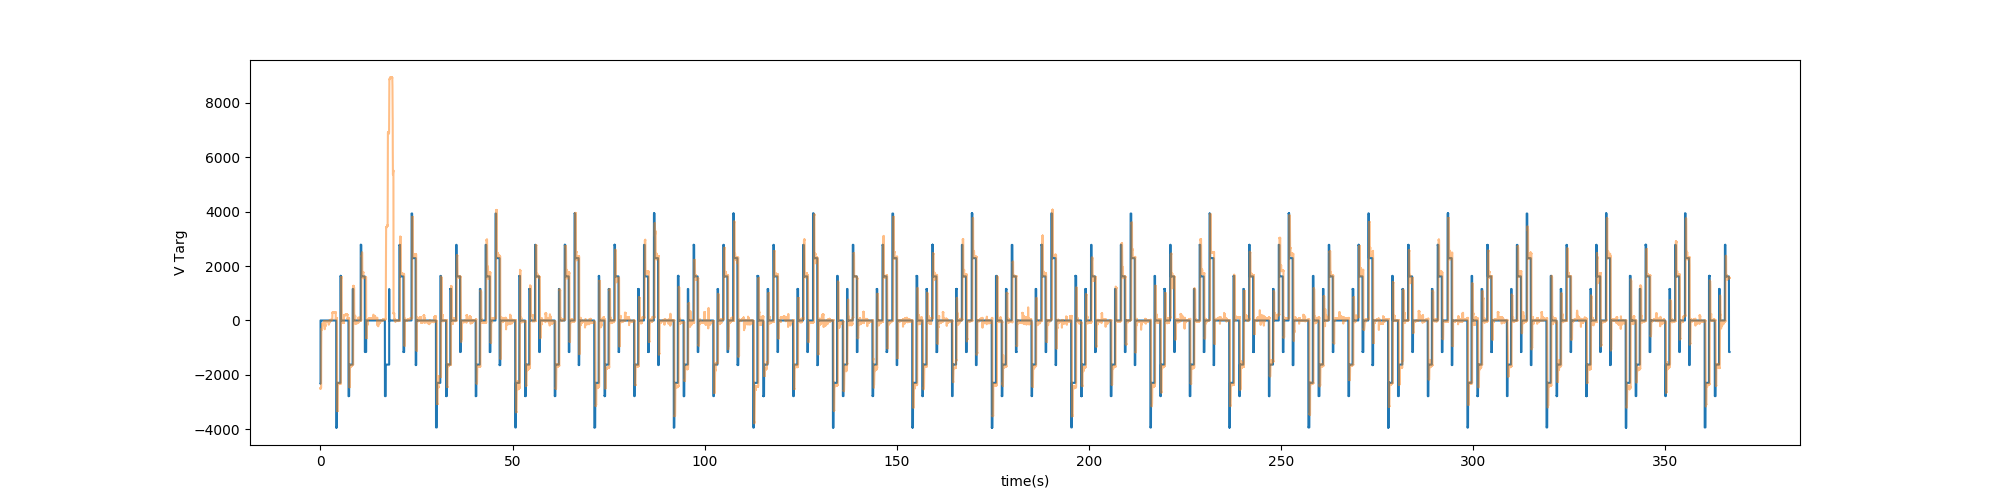

<IPython.core.display.Javascript object>


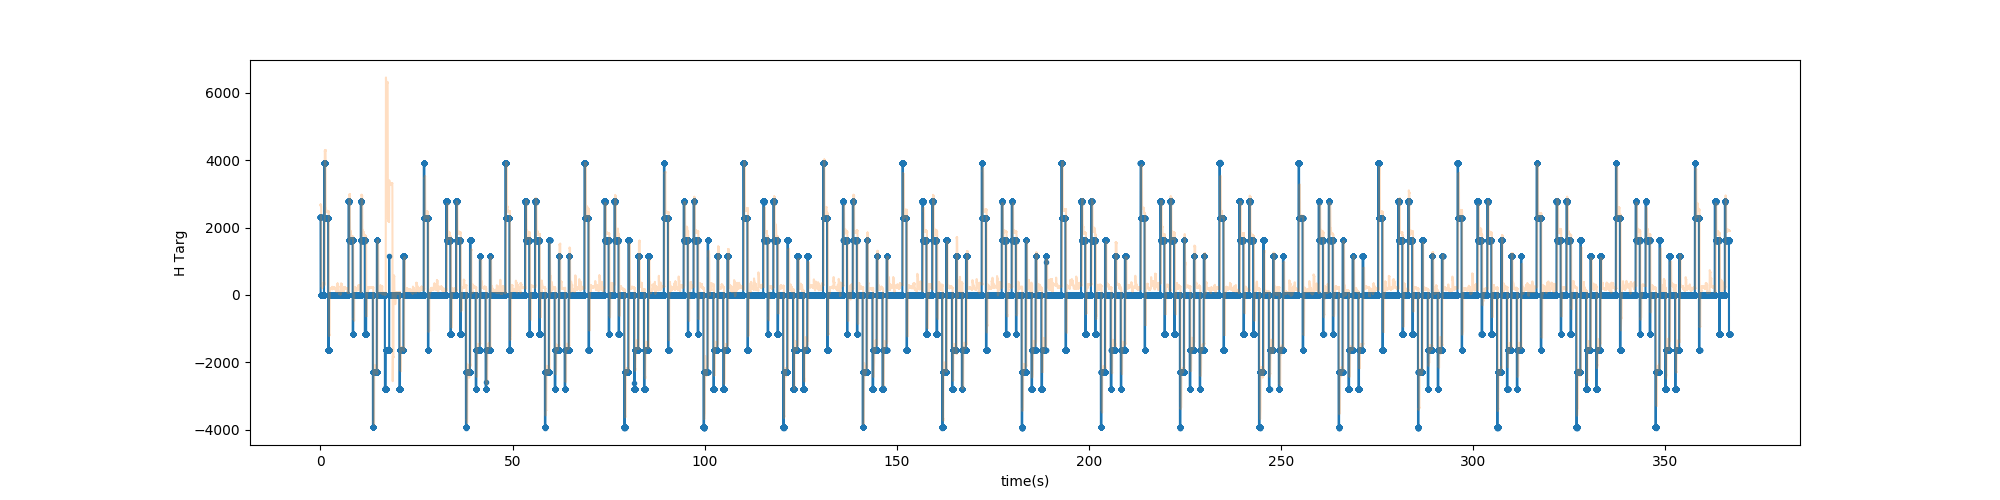

Text(0.5,0,u'time(s)')

In [137]:
vt = smr_content.get_channel(4)
ve = smr_content.get_channel(2)

ht = smr_content.get_channel(3)
he = smr_content.get_channel(1)

t_range = (0,700) #s
fsize =  (20,5)
i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange]/float(2*vt.divide))
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange]/float(2*ve.divide), alpha=0.5)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange])
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange], alpha=0.5)
plt.ylabel(vt.title)
plt.xlabel('time(s)')

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange]/float(2*ht.divide),'.-')
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange]/float(2*ht.divide), alpha=0.25)

plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange],'.-')
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange], alpha=0.25)

plt.ylabel(ht.title)
plt.xlabel('time(s)')


<IPython.core.display.Javascript object>


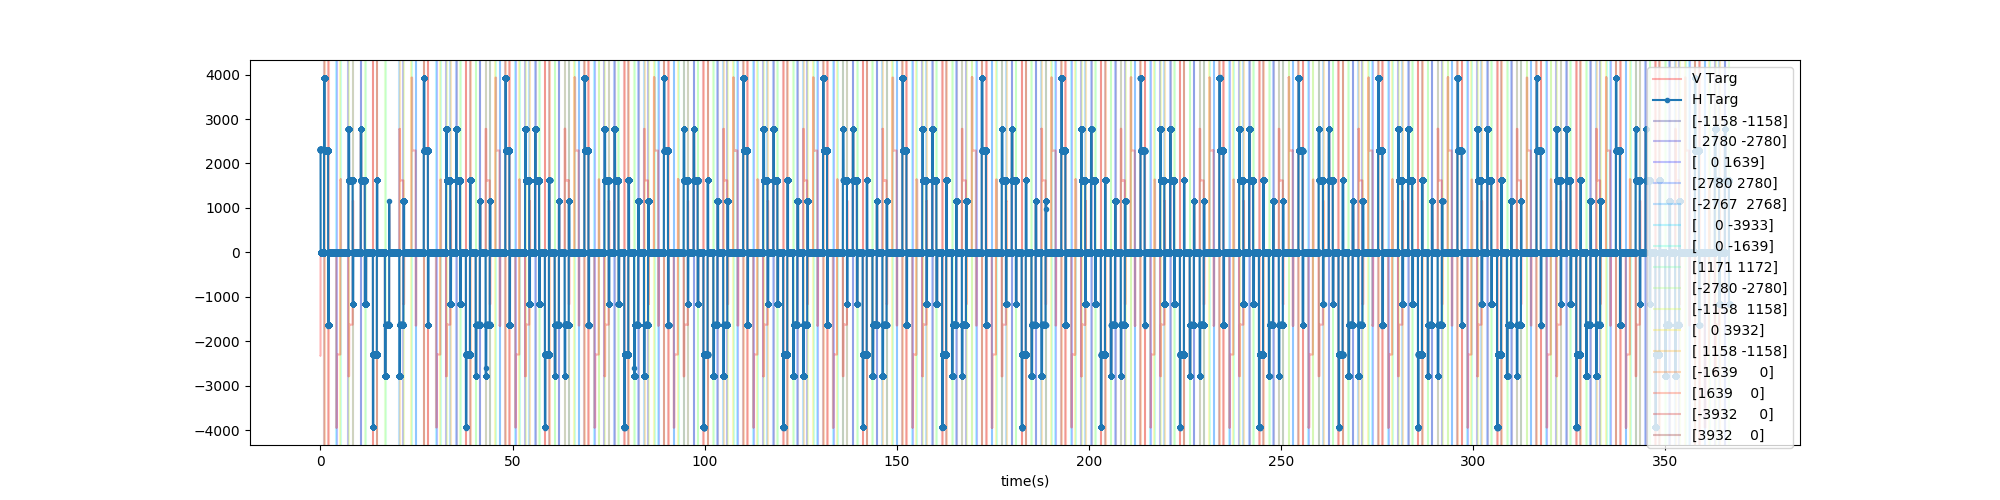

In [139]:
from kaveh.behavioral import oculomotor

tt = oculomotor.target(vt.data[prange], ht.data[prange], ht.dt, '2d')
target_jumps_to = tt.get_target_jumps(num_clusters=16, jump_tol= 100)

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange]/float(2*ht.divide),'.-')
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange]/float(2*ht.divide), alpha=0.25)

plt.plot(np.arange(0, tt.vt.size)*tt.dt, tt.vt, 'r', alpha = 0.3)
plt.plot(np.arange(0, tt.ht.size)*tt.dt, tt.ht, '.-')


# plt.ylabel(ht.title)
plt.xlabel('time(s)')


jump_amps = target_jumps_to.keys()
colors = plt.cm.jet(np.linspace(0, 1, len(jump_amps)))
for i, ja in enumerate(jump_amps):
    plots.axvlines(plt.gca(), target_jumps_to[ja]*tt.dt, alpha = 0.25, color=colors[i])        

legend_labels = [vt.title , ht.title] + [str(ja) for ja in jump_amps]
plt.legend(legend_labels)


In [134]:
np.linalg.norm((1200, 1200))

1697.0562748477141

<IPython.core.display.Javascript object>


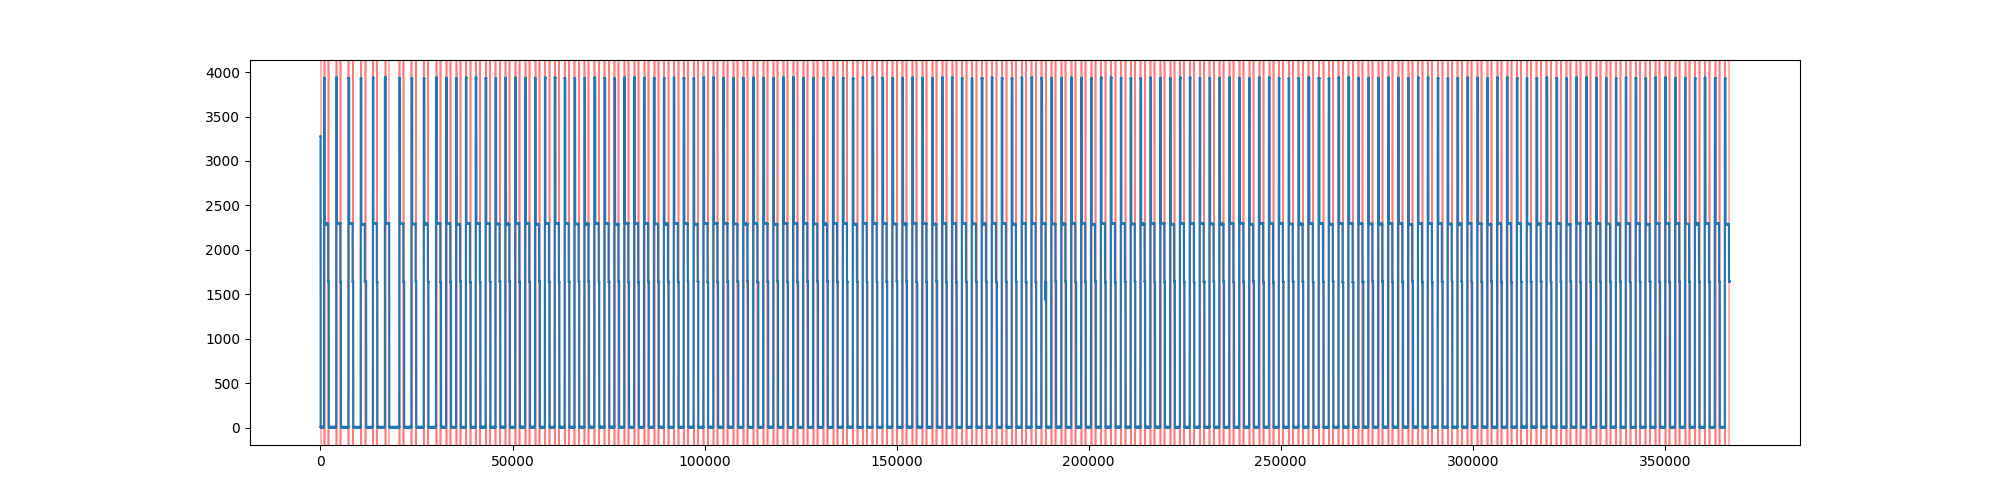

In [143]:
pos_2d = np.column_stack((vt.data[prange], ht.data[prange]))
pos_norm = np.linalg.norm(pos_2d, axis = -1)
plt.figure(figsize=fsize)
plt.plot(pos_norm)

In [144]:
import scipy.signal
# plt.figure()
# plt.plot(ht.data[prange],'.-')

# find target jumps
pos_diff = np.abs(np.diff(pos_norm))
target_jump_indices = scipy.signal.find_peaks(pos_diff, prominence=200)[0]


# remove detected target jumps that are sequential (less than 5 samples apart)
to_delete = []
for i, tji in enumerate(target_jump_indices[1:]):
    if tji - target_jump_indices[i] < 5:
        to_delete = to_delete + [i+1]
        print(i)
mask = np.ones(target_jump_indices.shape, dtype=bool)
mask[to_delete] = False
target_jump_indices = target_jump_indices[mask]

from kaveh.plots import axvlines
axvlines(plt.gca(), target_jump_indices, color='r', alpha=0.3 )


In [151]:
jump_vecs_h = []
for tji in target_jump_indices:
    jump_vecs_h = jump_vecs_h + [ht.data[prange][tji + 5] - ht.data[prange][tji - 5]]
jump_vecs_h = np.array(jump_vecs_h)    
    
jump_vecs_v = []
for tji in target_jump_indices:
    jump_vecs_v = jump_vecs_v + [vt.data[prange][tji + 5] - vt.data[prange][tji - 5]]
jump_vecs_v = np.array(jump_vecs_v)

In [ ]:
plt.figure()
plt.hist(jump_vecs_h)

In [155]:
jump_vecs = np.column_stack((jump_vecs_h, jump_vecs_v))


In [156]:
from sklearn.cluster import KMeans
#jump_vecs = np.array(jump_vecs).reshape(-1,1)
kmeans = KMeans(n_clusters=16, random_state=0).fit(jump_vecs)
jump_amps = kmeans.cluster_centers_
#jump_amps = np.array([int(ja) for ja in jump_amps])

In [157]:
jump_amps = np.int64(jump_amps)
print(jump_amps)


[[ 3932     0]
 [-1158  1158]
 [-1158 -1158]
 [    0  1639]
 [ 2780 -2780]
 [    0 -3933]
 [-3932     0]
 [ 1639     0]
 [ 2780  2780]
 [-2767  2768]
 [    0  3932]
 [-2780 -2780]
 [ 1171  1172]
 [ 1158 -1158]
 [-1639     0]
 [    0 -1639]]


In [106]:
jump_vecs[np.where(kmeans.labels_ == 1),:]


array([[[-2782,  2782],
        [-2779,  2781],
        [-2781,  2783],
        [-2783,  2781],
        [-2780,  2780],
        [-2780,  2780],
        [-2780,  2780],
        [-2782,  2782],
        [-2781,  2779],
        [-2780,  2780],
        [-2780,  2779],
        [-2781,  2782],
        [-2779,  2779],
        [-2779,  2780],
        [-2780,  2782],
        [-2780,  2781],
        [-2782,  2779],
        [-2781,  2781],
        [-2781,  2779],
        [-2783,  2782],
        [-2782,  2778],
        [-2782,  2783],
        [-2780,  2780],
        [-2780,  2779],
        [-2782,  2781],
        [-2779,  2781],
        [-2779,  2780],
        [-2782,  2781],
        [-2782,  2780],
        [-2781,  2783],
        [-2782,  2782],
        [-2781,  2779],
        [-2779,  2779],
        [-2781,  2781],
        [-2780,  2782],
        [-2778,  2781],
        [-2781,  2781],
        [-2780,  2780],
        [-2778,  2780],
        [-2782,  2782],
        [-2784,  2782],
        [-2782, 

In [113]:
target_jumps_to = {}
jump_tol = 200

for ja in jump_amps:
    target_jumps_to[str(ja)] = np.array([], dtype='int64')
for i, tji in enumerate(target_jump_indices):
    for ja in jump_amps:
        if (jump_vecs[i,0] < ja[0] + jump_tol and
            jump_vecs[i,0] >= ja[0] - jump_tol and
            jump_vecs[i,1] < ja[1] + jump_tol and
            jump_vecs[i,1] >= ja[1] - jump_tol):
            target_jumps_to[str(ja)] = np.concatenate((target_jumps_to[str(ja)], [tji]))
            
            
        
    


In [114]:
print(jump_vecs[1])

[ 1854 -1853]


<IPython.core.display.Javascript object>


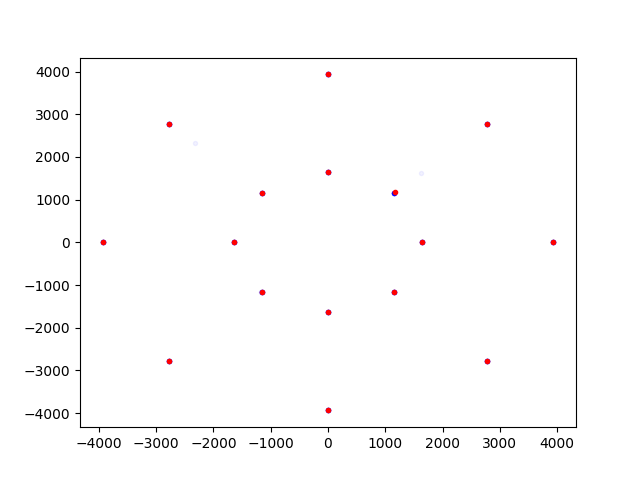

In [160]:
# plt.figure()
# plt.plot(jump_vecs_h/(ht.l_chan_dvd*ht.scale/10.0), jump_vecs_v/(vt.l_chan_dvd*vt.scale/10.0), '.b', alpha = 0.05)
# plt.plot(jump_amps[:,0]/(ht.l_chan_dvd*ht.scale/10.0), jump_amps[:,1]/(vt.l_chan_dvd*vt.scale/10.0), '.r', alpha=1)

plt.figure()
plt.plot(jump_vecs_h, jump_vecs_v, '.b', alpha = 0.05)
plt.plot(jump_amps[:,0], jump_amps[:,1], '.r', alpha=1)

<IPython.core.display.Javascript object>


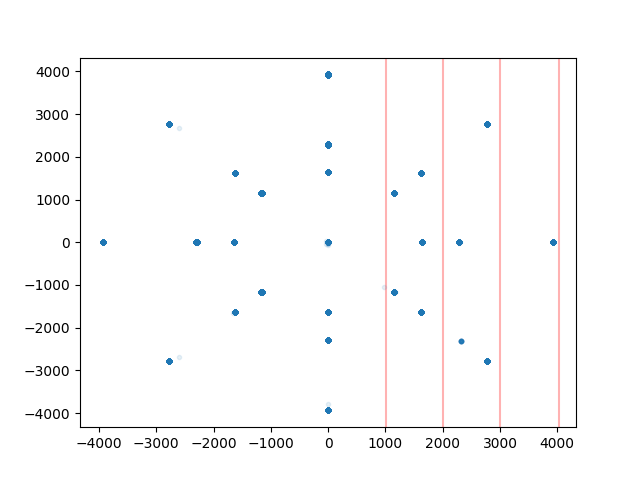

In [140]:
plt.figure()
# plt.plot(ht.data[prange]/(ht.l_chan_dvd*ht.scale/10.0), vt.data[prange]/(vt.l_chan_dvd*vt.scale/10.0), '.', alpha=0.1)
plt.plot(ht.data[prange], vt.data[prange], '.', alpha=0.1)

<IPython.core.display.Javascript object>


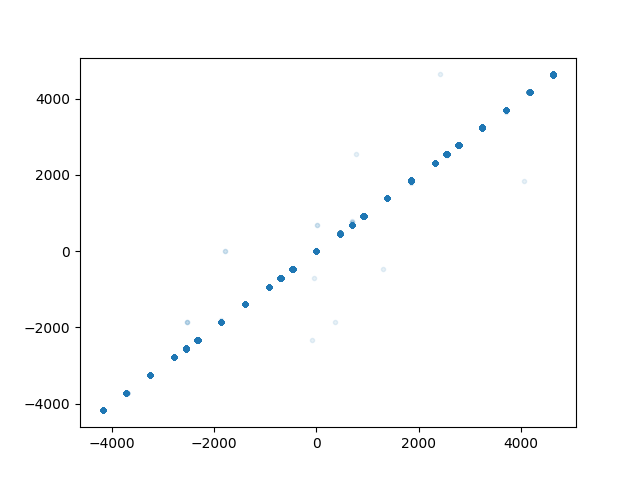

In [57]:
plt.figure()
# plt.plot(ht.data[prange]/(ht.l_chan_dvd*ht.scale/10.0), vt.data[prange]/(vt.l_chan_dvd*vt.scale/10.0), '.', alpha=0.1)
plt.plot(ht.data[prange], vt.data[prange], '.', alpha=0.1)

In [ ]:
%matplotlib inline
import time
# import pylab as pl
from IPython import display
plt.figure(figsize=(10,10))

for i in range(i_range[0], i_range[1], 10):
    plt.plot(ht.data[i],vt.data[i], 'or')
    plt.ylim((-5000,5000))
    plt.xlim((-5000,5000))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.001)
    plt.cla()
#     plt.cla()